# Demo - Fairness Analysis of COMPAS by ProPublica

Based on: https://github.com/propublica/compas-analysis

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.

## Imports

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.formula.api as smf

from ethically.dataset import COMPASDataset

## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [2]:
compas_ds = COMPASDataset()
df = compas_ds.df

len(df)

6172

Higher COMPAS scores are slightly correlated with a longer length of stay. 

In [3]:
stats.pearsonr(df['length_of_stay'].astype(int), df['decile_score'])

(0.20741201943031592, 5.943991686932148e-61)

After filtering we have the following demographic breakdown:

In [4]:
df['age_cat'].value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [5]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [6]:
(((df['race'].value_counts() / len(df))
  * 100)
 .round(2))

African-American    51.44
Caucasian           34.07
Hispanic             8.25
Other                5.56
Asian                0.50
Native American      0.18
Name: race, dtype: float64

In [7]:
df['score_text'].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [8]:
pd.crosstab(df['sex'], df['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [9]:
(((df['sex'].value_counts() / len(df))
  * 100)
 .round(2))

Male      80.96
Female    19.04
Name: sex, dtype: float64

In [10]:
df['two_year_recid'].value_counts()

0    3363
1    2809
Name: two_year_recid, dtype: int64

In [11]:
(((df['two_year_recid'].value_counts() / len(df))
  * 100)
 .round(2))

0    54.49
1    45.51
Name: two_year_recid, dtype: float64

Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

In [12]:
RACE_IN_FOCUS = ['African-American', 'Caucasian']
df_race_focused = df[df['race'].isin(RACE_IN_FOCUS)]

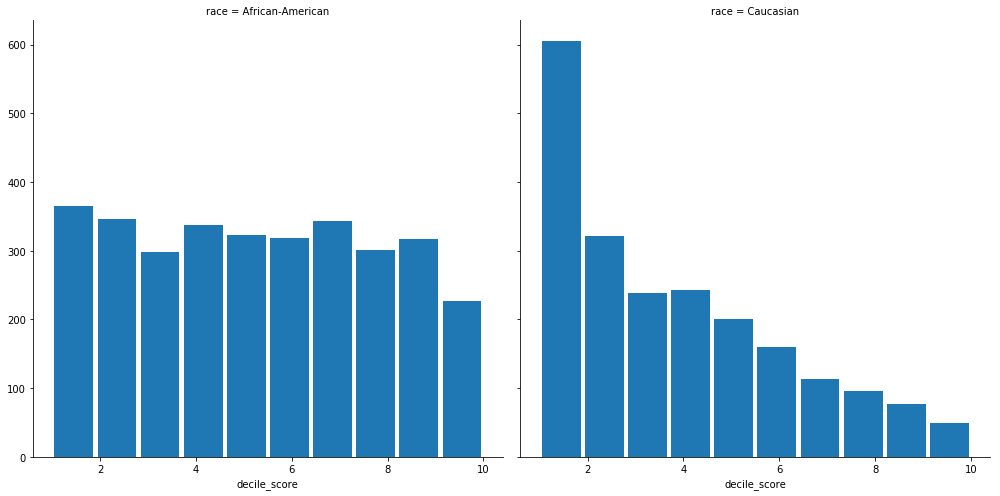

In [13]:
g = sns.FacetGrid(df_race_focused, col='race', height=7)#, aspect=4,)
g.map(plt.hist, 'decile_score', rwidth=0.9);

In [14]:
pd.crosstab(df['decile_score'], df['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


## Fairness Demographic Classification Criteria

Based on: https://fairmlbook.org/demographic.html

In [15]:
from ethically.fairness.metrics import (independence_binary,
                                        separation_binary,
                                        sufficiency_binary)

### Independence

In [28]:
indp, indp_cmp = independence_binary((df_race_focused['decile_score'] > 4),
                                     df_race_focused['race'],
                                     'Caucasian',
                                     as_df=True)

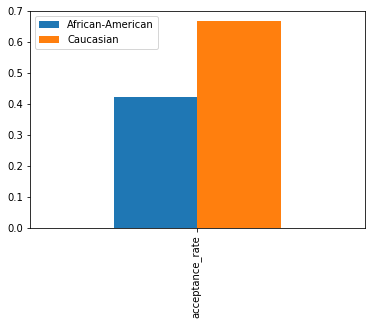

In [26]:
indp.plot(kind='bar')

In [27]:
indp_cmp

,acceptance_rate
African-American vs. Caucasian,
diff,-0.245107
ratio,0.633646


### Separation

In [19]:
sep, sep_cmp = separation_binary(df_race_focused['two_year_recid'],
                                 (df_race_focused['decile_score'] > 4),
                                 df_race_focused['race'],
                                 'Caucasian',
                                as_df=True)

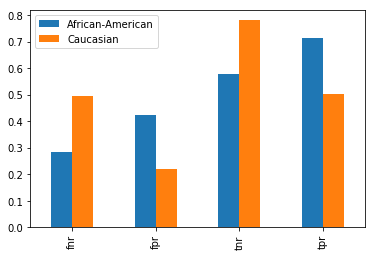

In [20]:
sep.plot(kind='bar');

In [21]:
sep_cmp

,tpr,fpr,tnr,fnr
African-American vs. Caucasian,,,,
diff,0.211582,0.203241,-0.203241,-0.211582
ratio,1.420098,1.923234,0.739387,0.573724


### Sufficiency

In [22]:
suff, suff_cmp = sufficiency_binary(df_race_focused['two_year_recid'],
                                   (df_race_focused['decile_score'] > 4),
                                   df_race_focused['race'],
                                   'Caucasian',
                                   as_df=True)

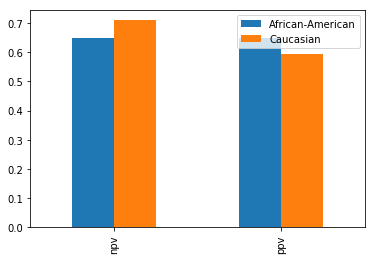

In [23]:
suff.plot(kind='bar');

In [24]:
suff_cmp

,ppv,npv
African-American vs. Caucasian,,
diff,0.054708,-0.061433
ratio,1.091972,0.913477
